# Dense Neural Network Regression Example: Air Quality Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras

2025-05-16 23:57:04.906636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the Dataset

Data Source: https://archive.ics.uci.edu/dataset/360/air+quality

In [5]:
df = pd.read_csv("../Day02/Data/AirQualityUCI.csv", sep=';', decimal=',')

In [6]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


## Data Preprocessing

- Remove columns with too many missing values
- Drop non-numeric columns
- Fill or drop missing values
- Select a target variable (e.g., 'C6H6(GT)')

In [7]:
# Drop last two columns (unnamed, empty)
df = df.iloc[:, :-2]

# Drop rows with missing values
df = df.replace(-200, np.nan)
df = df.dropna()

# Drop non-numeric columns
df = df.select_dtypes(include=[np.number])

In [8]:
# Select features and target
target = 'C6H6(GT)'
X = df.drop(columns=[target])
y = df[target]

## Train-Test Split and Scaling

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Compare Multiple Neural Network Architectures

### Sequential Models

In [10]:
# Model 1: Simple Sequential (1 hidden layer)
seq_model_1 = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(1)
])
seq_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/conda/envs/tf_makeenv2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Model 2: Deeper Sequential (2 hidden layers)
seq_model_2 = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
seq_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
# Model 3: Sequential with Dropout
seq_model_3 = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])
seq_model_3.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Functional API Models

In [13]:
# Model 4: Functional API with skip connection
inputs = keras.Input(shape=(X_train_scaled.shape[1],))
x = keras.layers.Dense(64, activation='relu')(inputs)
x_skip = keras.layers.Dense(32, activation='relu')(x)
concat = keras.layers.Concatenate()([x, x_skip])
outputs = keras.layers.Dense(1)(concat)
func_model_1 = keras.Model(inputs=inputs, outputs=outputs)
func_model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [14]:
# Model 5: Functional API with multiple branches
inputs = keras.Input(shape=(X_train_scaled.shape[1],))
branch1 = keras.layers.Dense(64, activation='relu')(inputs)
branch2 = keras.layers.Dense(32, activation='relu')(inputs)
merged = keras.layers.Concatenate()([branch1, branch2])
x = keras.layers.Dense(32, activation='relu')(merged)
outputs = keras.layers.Dense(1)(x)
func_model_2 = keras.Model(inputs=inputs, outputs=outputs)
func_model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

## Train All Models

In [15]:
models = {
    'Sequential_1': seq_model_1,
    'Sequential_2': seq_model_2,
    'Sequential_3': seq_model_3,
    'Functional_1': func_model_1,
    'Functional_2': func_model_2
}
histories = {}
for name, model in models.items():
    print(f'Training {name}...')
    histories[name] = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=32,
        verbose=0
    )

Training Sequential_1...
Training Sequential_2...
Training Sequential_2...
Training Sequential_3...
Training Sequential_3...
Training Functional_1...
Training Functional_1...
Training Functional_2...
Training Functional_2...


## Evaluate and Compare Model Performance

In [16]:
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test_scaled).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name}: MSE={mse:.2f}, R2={r2:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Sequential_1: MSE=7.34, R2=0.88
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/stepSequential_1: MSE=7.34, R2=0.88
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Sequential_2: MSE=0.54, R2=0.99
Sequential_2: MSE=0.54, R2=0.99
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fe368684cc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing 

## Plot Training Loss for All Models

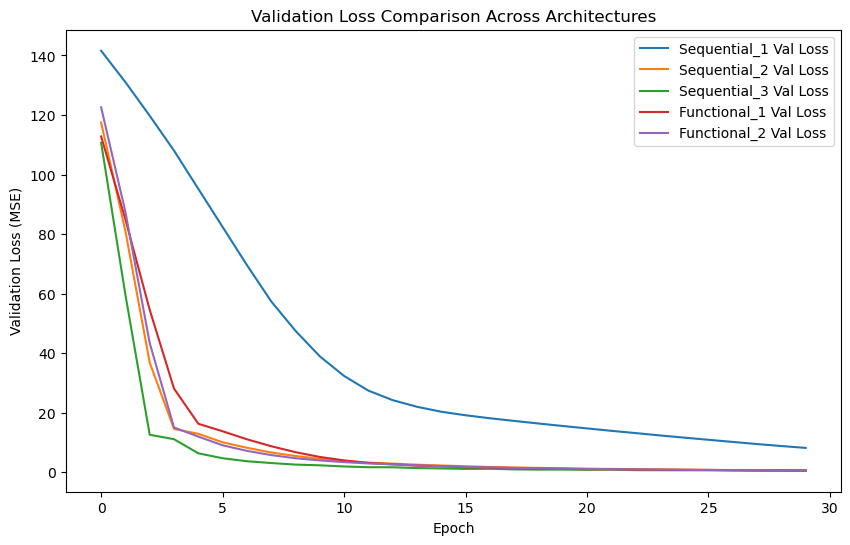

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
for name, hist in histories.items():
    plt.plot(hist.history['val_loss'], label=f'{name} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (MSE)')
plt.legend()
plt.title('Validation Loss Comparison Across Architectures')
plt.show()

## Visualize All Model Architectures

Sequential_1,Sequential_2,Sequential_3,Functional_1,Functional_2


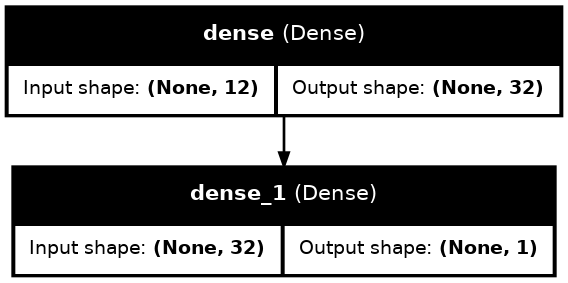

Sequential_1


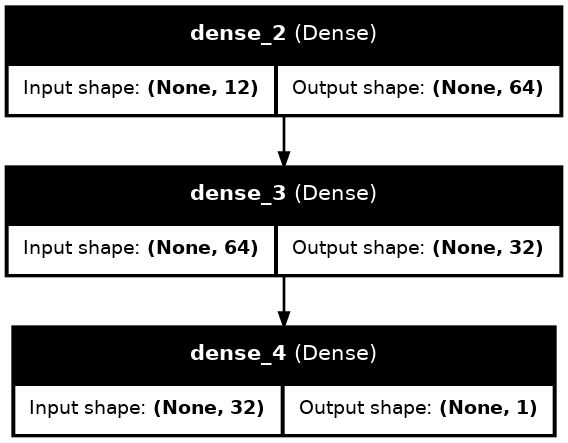

Sequential_2


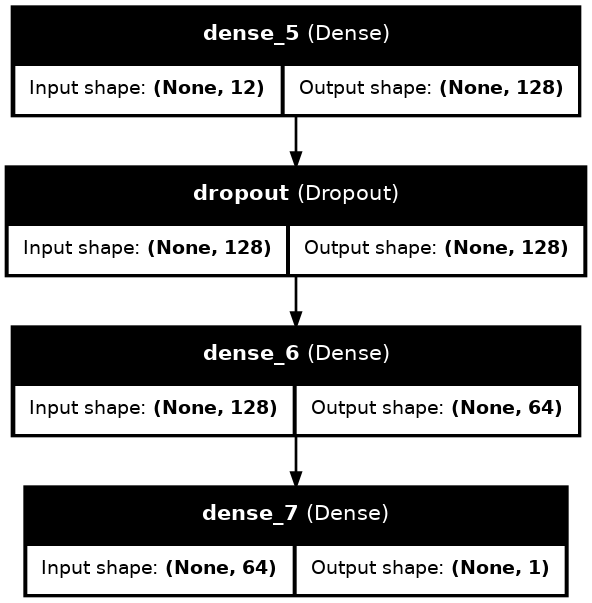

Sequential_3


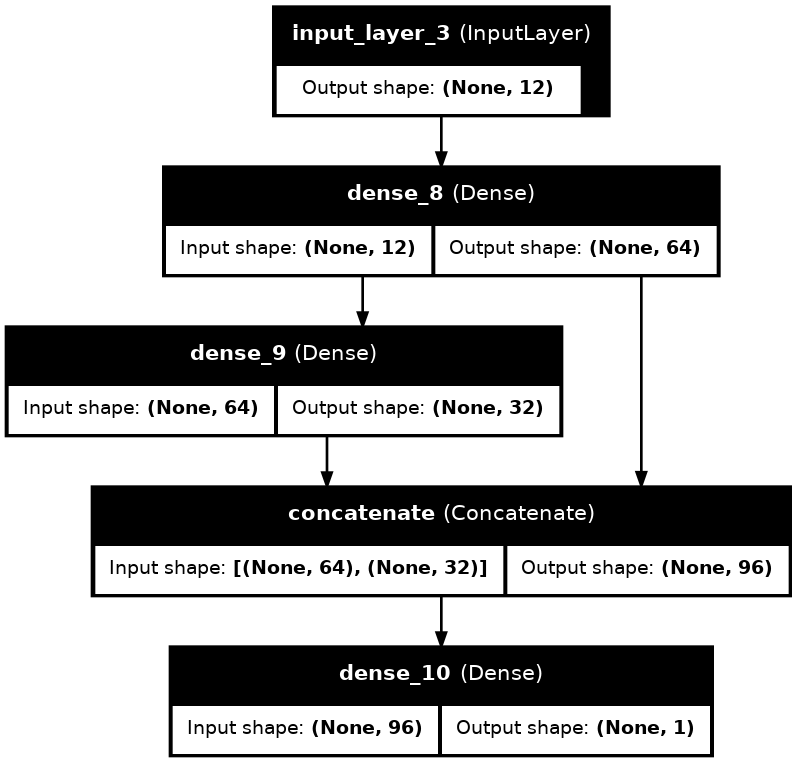

Functional_1


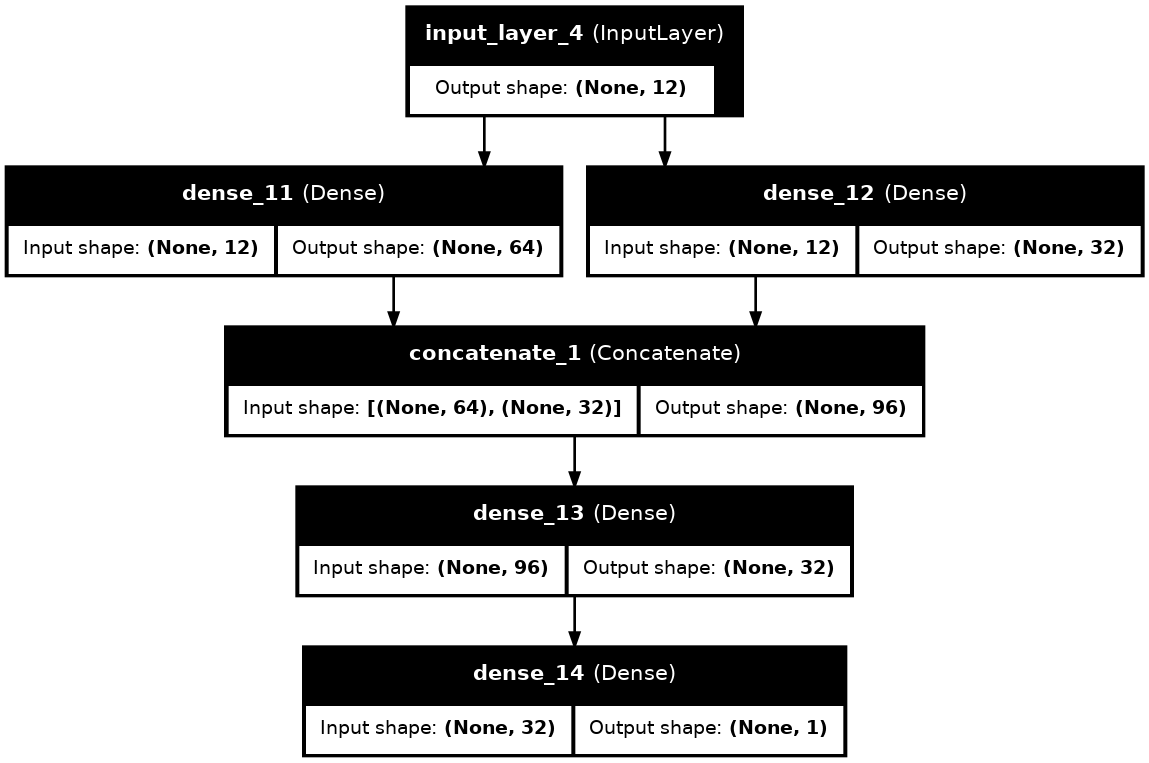

Functional_2


In [22]:
from IPython.display import display, Image
import tempfile

model_names = list(models.keys())
figures = []
for name in model_names:
    with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmpfile:
        tf.keras.utils.plot_model(models[name], to_file=tmpfile.name, show_shapes=True, show_layer_names=True, rankdir="TB", dpi=96)
        figures.append((name, tmpfile.name))

# Display all model architectures side by side
from IPython.display import HTML
html = "<table><tr>"
for name, img_path in figures:
    html += f'<td style="text-align:center"><b>{name}</b><br><img src="{img_path}" width="300"></td>'
html += "</tr></table>"
display(HTML(html))
from IPython.display import display
for name, img_path in figures:
    display(Image(filename=img_path, width=300))
    print(name)